In [1]:
import royale.cards as cards
import royale.battlelog as bl
import json
import numpy as np

In [2]:
def extract_avg_elixir(player):

    with open('./royale/cards_dict.json', "r", encoding="utf-8") as f:
        cards_dict = json.load(f)    

    deck = cards._extract_side(player[0])['deck']
    
    avg_e1=[]
    for c in deck:
        cid = str(c['id'])
        elixir = cards_dict[cid]['elixirCost']
        avg_e1.append(elixir) 
        
    return np.mean(avg_e1)


with open('./data/mine/#88V8GQU.json', "r", encoding="utf-8") as f:
    battles = json.load(f)

# cards.show_match_decks(battles[0])
print(extract_avg_elixir(battles[1]['opponent']))     

3.0


In [3]:
def winner_and_crowns(match):
    team1 = match.get("team", [])
    team2 = match.get("opponent", [])
    crowns1 = cards._extract_side(team1[0])['crowns']
    crowns2 = cards._extract_side(team2[0])['crowns']
    if crowns1 > crowns2:
        w1=1
        w2=0
    elif crowns1 < crowns2:
        w1=0
        w2=1
    else:
        w1=0
        w2=0
    return w1, crowns1, w2, crowns2  

with open('./data/mine/#88V8GQU.json', "r", encoding="utf-8") as f:
    battles = json.load(f)

# cards.show_match_decks(battles[0])
print(winner_and_crowns(battles[0])) 

(0, 0, 1, 1)


Risultato: FIERO! #88V8GQU  0 - 1  SAYAYIN #QCC2GJ2GU


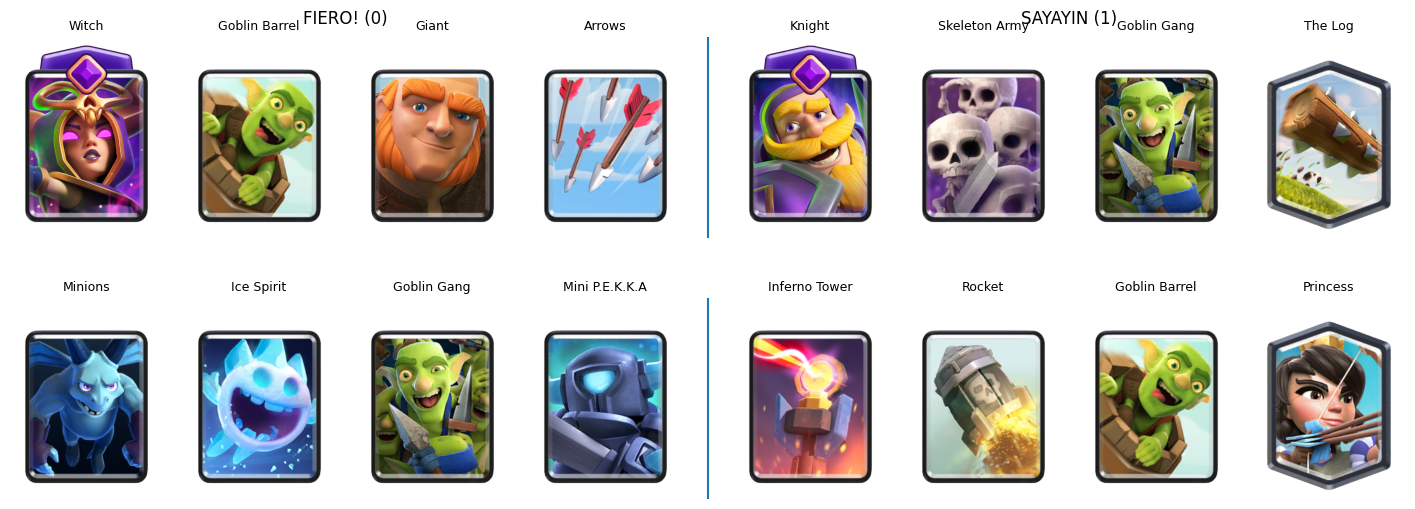

{'cycle': False, 'beatdown': False, 'bait': True, 'siege': False, 'DIY': False}


In [4]:
def define_archetype_deck(player):
    decK = cards._extract_side(player[0])['deck']
    ids = [str(c['id']) for c in decK]
    
    with open('./royale/cards_dict.json', "r", encoding="utf-8") as f:
        cards_dict = json.load(f)     
    
    archetype = {'cycle':False, 'beatdown':False, 'bait':False, 'siege':False, 'DIY':False}
    
    siege=['27000008','27000002'] #x-bow, mortar
    tanks = ["26000009","26000055","26000029","26000085","26000004","26000020","26000003","26000099","26000069","26000101"] #golem, mega knight, lava hound, E giant, pekka, giant skeleton, goblin giant, giant, goblinstein, skeleton king, rune giant
    baiters = ["26000002","26000019","26000040","26000041","28000004","26000026","26000012","26000058","26000097","26000064","27000013","26000056"] #goblins,spear goblins, dart goblin, goblin gang, goblin barrel, princess, skeleton army, wall brakers, bush, firecracker, goblin drill, skeleton barrel
    
    cycle_max_average_elixir = 3
    betdown_min_average_elixir = 4
    
    avg_elixir = extract_avg_elixir(player)
    
    if any(s in ids for s in siege):
        archetype['siege'] = True
    
    if avg_elixir < cycle_max_average_elixir:
        archetype['cycle'] = True
    
    if avg_elixir > betdown_min_average_elixir and any(t in ids for t in tanks):
        archetype['beatdown'] = True
    
    if sum(b in ids for b in baiters) >= 3:
        archetype['bait'] = True

        
    count_true = sum(v for k, v in archetype.items() if k != "DIY")

    if count_true == 0 or count_true > 1:
        archetype["DIY"] = True
    
    return archetype

with open('./data/mine/#88V8GQU.json', "r", encoding="utf-8") as f:
    battles = json.load(f)

cards.show_match_decks(battles[-1])
print(define_archetype_deck(battles[-1]['opponent']))     

In [2]:
with open('./royale/cards_dict.json', "r", encoding="utf-8") as f:
    cards_dict = json.load(f)

for i, (cid, c) in enumerate(cards_dict.items()):
    c['loc'] = i   # aggiungi la posizione

print(len(cards_dict))


121


In [ ]:
import numpy as np
from itertools import combinations

tag = '#88V8GQU'       # tag corrente
prev_tag = None        # tag precedente (per evitare ping-pong)
counting = 10000
cxc = np.zeros((len(cards_dict), len(cards_dict)), dtype=np.int32)

cursors = {}           # cursore per ogni tag: prossimo indice da provare nel suo battle_log
logs_cache = {}        # opzionale: cache dei battle log per non richiamare sempre l'API
visited = set()        # per non contare due volte lo stesso scontro (battleTime + pair tag)
decks=[]

processed = 0
stalls = 0             # protezione da loop infiniti
max_stalls = 5 * counting

while processed < counting and stalls < max_stalls:
    # prendi (o scarica) il battle log del tag corrente
    log = logs_cache.get(tag)
    if log is None:
        log = bl.get_battlelog(tag) or []
        logs_cache[tag] = log
        cursors.setdefault(tag, 0)

    i = cursors[tag]
    found = False
    # scorri dal cursore in giù (il "match sotto")
    while i < len(log):
        m = log[i]
        i += 1

        # filtri robusti
        if m.get('gameMode', {}).get('name') != 'Ladder':
            continue
        opp_list = m.get('opponent') or []
        if not opp_list:
            continue

        opp_tag = opp_list[0].get('tag')
        deck = opp_list[0].get('cards') or []
        if not opp_tag or not deck:
            continue

        bt = m.get('battleTime')
        battle_id = (bt, tuple(sorted([tag, opp_tag])))
        if battle_id in visited:
            continue

        # evita rimbalzo immediato
        if opp_tag == prev_tag:
            continue

        # match valido trovato
        found = True
        cursors[tag] = i  # la prossima volta ripartirai dal match dopo questo
        break

    if not found:
        # Nessun match valido per questo tag: torna al tag precedente e vai al "match sotto" di quello
        stalls += 1
        if prev_tag is None:
            # Se non hai un precedente, avanza comunque il cursore e riprova
            cursors[tag] = i
            continue
        # swap: torna indietro
        tag, prev_tag = prev_tag, tag
        continue

    # aggiorna la co-occorrenza (submatrice +1)
    idxs = [
        cards_dict.get(str(c.get('id')), {}).get('loc')
        for c in deck
    ]
    idxs = [k for k in idxs if k is not None]
    if idxs:
        I = np.ix_(idxs, idxs)
        cxc[I] += 1
        
        # --- salva gli id delle carte del deck ---
        deck_ids = [str(c['id']) for c in deck if 'id' in c]
        decks.append(deck_ids)

    visited.add(battle_id)
    prev_tag, tag = tag, opp_tag
    processed += 1
    
    if processed % 100 == 0:
        print(processed/counting *100, '%')
    # print(processed, tag)

print("Deck processati:", processed)

    
import matplotlib.pyplot as plt

# Costruisco lista etichette indice -> nome/id
idx_to_label = [None] * len(cards_dict)
for cid, info in cards_dict.items():
    idx = info['loc']
    label = info.get('name', cid)
    idx_to_label[idx] = label

# Calcolo dimensione dinamica della figura
n_cards = len(idx_to_label)
figsize = (n_cards * 0.3, n_cards * 0.3)  # scala le dimensioni
fig, ax = plt.subplots(figsize=figsize, dpi=200)

# Disegna la matrice con griglia bianca
im = ax.pcolormesh(cxc/counting, cmap="viridis", edgecolors="w", linewidth=0.01)

cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Co-occorrenza normalizzata', rotation=90)

ax.set_title('Matrice di co-occorrenza (normalizzata)', fontsize=40)

# Tick come prima
max_labels = 121
step = max(1, n_cards // max_labels)
ticks = list(range(0, n_cards, step))
ax.set_xticks([t + 0.5 for t in ticks])  # spostati di mezzo pixel
ax.set_yticks([t + 0.5 for t in ticks])
ax.set_xticklabels([idx_to_label[i] for i in ticks], rotation=90, ha="right", fontsize=12)
ax.set_yticklabels([idx_to_label[i] for i in ticks], fontsize=12)
ax.invert_yaxis()

plt.tight_layout()
plt.show()


1.0 %
2.0 %
3.0 %
4.0 %
5.0 %
6.0 %
7.000000000000001 %
8.0 %
9.0 %
10.0 %


In [ ]:
np.savetxt("cxc.csv", cxc, delimiter=",", fmt="%d")

# Salva su file JSON
with open("decks_dataset.json", "w", encoding="utf-8") as f:
    json.dump(decks, f, indent=2, ensure_ascii=False)

print(f"Salvati {len(decks)} deck in decks_dataset.json")
